In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM



root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [11]:
acc_eachcoord = np.zeros((n_subjects, n_rois, n_tasks, 2, 4))
conf_eachcoord = np.zeros((n_subjects, n_rois, n_tasks, 2, 4))

un_coord = np.unique(grid_pts[:,0])

# pairs_do = [un_coord[[0,1]], un_coord[[1,2]], un_coord[[2,3]]]

# pair_names = ['%s vs %s'%(p1,p2) for p1,p2 in pairs_do]

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
  
        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T

        is_main_grid = l['is_main_grid']==1
        
        for ii in [0,1]:

            coord_actual = pt_labs[:,ii].round(2)
            
            for ci, uu in enumerate(un_coord):
                
                # pair = pairs_do[pi]

                inds = (coord_actual==uu) & is_main_grid
                # print(np.sum(inds))
                
                for ri in range(n_rois):
                    
                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

                    # predicted coordinate along axis of interest
                    coord_pred = grid_pts[pred][:,ii]
                    
                   
                    acc = np.mean(coord_actual[inds]==coord_pred[inds])
                    
                    acc_eachcoord[si, ri, ti, ii, ci] = acc
                    
                    
                    probs = dec_withintask['probs_all'][si][ri][ti]

                    p_categ = np.sum(probs[:,grid_pts[:,ii]==uu], axis=1)
                    
                    conf_eachcoord[si, ri, ti, ii, ci] = np.mean(p_categ[inds])



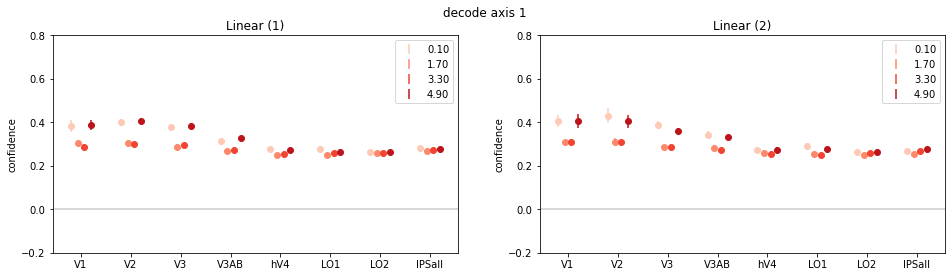

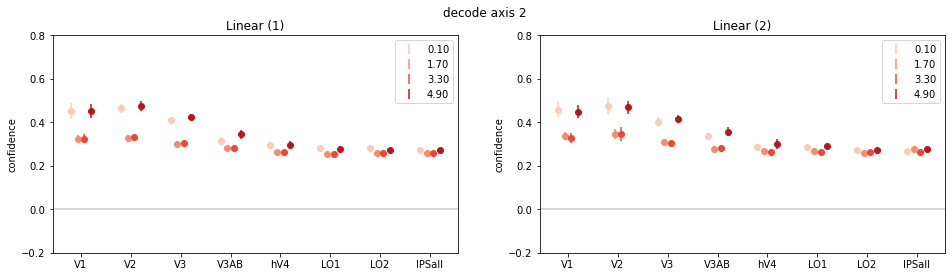

In [14]:
coord_colors = cm.Reds(np.linspace(0,1,6))[1:5,:]
coord_names = ['%.2f'%uu for uu in un_coord]

x_jitter = np.linspace(-0.2, 0.2, 4)

for ii, axis_name in enumerate(['axis 1','axis 2']):
    
    plt.figure(figsize=(16,4))

    for ti, task_name in enumerate(task_names[0:2]):

        plt.subplot(1,2,ti+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ci, coord_name in enumerate(coord_names):

            x_ticks = np.arange(n_rois) + x_jitter[ci]

            vals = conf_eachcoord[:,:,ti,ii,ci]
        
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=coord_colors[ci])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=coord_colors[ci], linestyle='none')
            lh.append(h)
          
        plt.ylim([-0.2, 0.8])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,coord_names)

        plt.title(task_names[ti])

    plt.suptitle('decode %s'%axis_name)


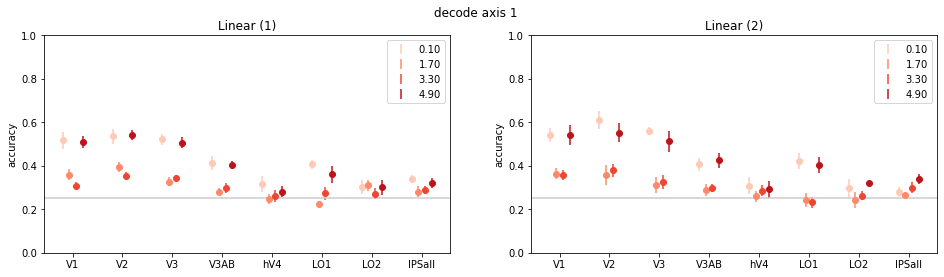

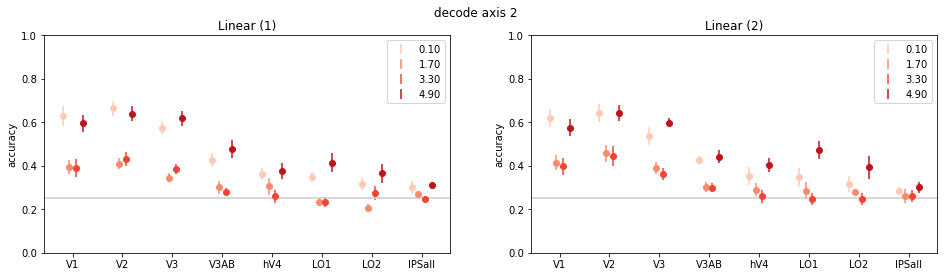

In [15]:
coord_colors = cm.Reds(np.linspace(0,1,6))[1:5,:]
coord_names = ['%.2f'%uu for uu in un_coord]

x_jitter = np.linspace(-0.2, 0.2, 4)

for ii, axis_name in enumerate(['axis 1','axis 2']):
    
    plt.figure(figsize=(16,4))

    for ti, task_name in enumerate(task_names[0:2]):

        plt.subplot(1,2,ti+1)

        plt.axhline(1/4, color=[0.8, 0.8, 0.8])

        lh = []

        for ci, coord_name in enumerate(coord_names):

            x_ticks = np.arange(n_rois) + x_jitter[ci]

            vals = acc_eachcoord[:,:,ti,ii,ci]
        
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=coord_colors[ci])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=coord_colors[ci], linestyle='none')
            lh.append(h)
          
        plt.ylim([0, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('accuracy')

        plt.legend(lh,coord_names)

        plt.title(task_names[ti])

    plt.suptitle('decode %s'%axis_name)


In [16]:
acc_eachcoordpair = np.zeros((n_subjects, n_rois, n_tasks, 2, 3))
conf_eachcoordpair = np.zeros((n_subjects, n_rois, n_tasks, 2, 3))

un_coord = np.unique(grid_pts[:,0])

pairs_do = [un_coord[[0,1]], un_coord[[1,2]], un_coord[[2,3]]]

pair_names = ['%s vs %s'%(p1,p2) for p1,p2 in pairs_do]

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
  
        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T

        is_main_grid = l['is_main_grid']==1
        
        for ii in [0,1]:

            coord_actual = pt_labs[:,ii].round(2)
            
            for pi in [0,1,2]:
                
                pair = pairs_do[pi]

                inds = np.isin(coord_actual, pair) & is_main_grid
                
                for ri in range(n_rois):
                    
                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

                    # predicted coordinate along axis of interest
                    coord_pred = grid_pts[pred][:,ii]
                    
                    # round the predictions to nearest value within the current pair of corods
                    pair_pred = np.zeros_like(coord_pred)
                    for uu in un_coord:
                        idx = coord_pred==uu
                        val = pair[np.argmin(np.abs(pair-uu))]
                        pair_pred[idx] = val
                      
                    # assert(np.all(np.isin(coord_actual[inds], pair)))
                    
                    # acc = np.mean(coord_actual[inds]==pair_pred[inds])
                    
                    acc = np.mean(coord_actual[inds]==coord_pred[inds])
                    
                    acc_eachcoordpair[si, ri, ti, ii, pi] = acc
                    
                    
                    probs = dec_withintask['probs_all'][si][ri][ti]

                    # sum the probabilities within each unique coord along this axis
                    p_eachcoord = np.array([np.sum(probs[:,grid_pts[:,ii]==uu], axis=1) \
                                            for uu in un_coord]).T
                    # print(np.mean(p_eachcoord, axis=0))
#                     nearest_pair = [pair[np.argmin(np.abs(pair-uu))] for uu in un_coord]
                    
#                     p_categ1 = np.mean(p_eachcoord[:,nearest_pair==pair[0]], axis=1)
#                     p_categ2 = np.mean(p_eachcoord[:,nearest_pair==pair[1]], axis=1)
#                     
                    p_categ1 = np.sum(probs[:,grid_pts[:,ii]==pair[0]], axis=1)
                    p_categ2 = np.sum(probs[:,grid_pts[:,ii]==pair[1]], axis=1)

                    # print(pair)
            
                    # print(np.mean(p_categ1[inds]), np.mean(p_categ2[inds]))
                    signedconf = np.zeros_like(p_categ1)
                    # signedconf[coord_actual==pair[0]] = \
                    #     p_categ1[coord_actual==pair[0]] - p_categ2[coord_actual==pair[0]]
                    # signedconf[coord_actual==pair[1]] = \
                    #     p_categ2[coord_actual==pair[1]] - p_categ1[coord_actual==pair[1]]
                    signedconf[coord_actual==pair[0]] = p_categ1[coord_actual==pair[0]]
                    signedconf[coord_actual==pair[1]] = p_categ2[coord_actual==pair[1]]
                    
                    assert(np.all(signedconf[inds]!=0))
                    
                    conf_eachcoordpair[si, ri, ti, ii, pi] = np.mean(signedconf[inds])



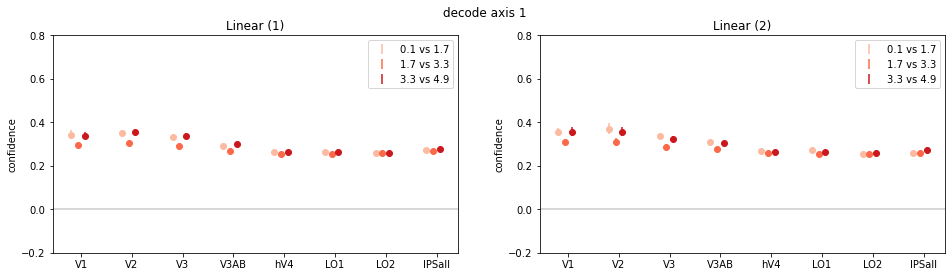

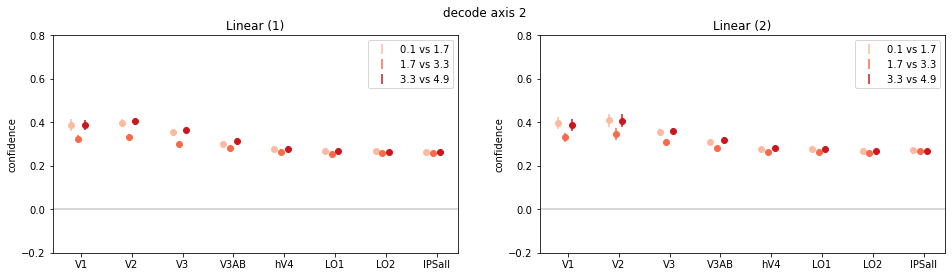

In [19]:
pair_colors = cm.Reds(np.linspace(0,1,5))[1:4,:]
pair_names = ['%s vs %s'%(p1,p2) for p1,p2 in pairs_do]

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

for ii, axis_name in enumerate(['axis 1','axis 2']):
    
    plt.figure(figsize=(16,4))

    for ti, task_name in enumerate(task_names[0:2]):

        plt.subplot(1,2,ti+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for pi, pair_name in enumerate(pair_names):

            x_ticks = np.arange(n_rois) + x_jitter[pi]

            vals = conf_eachcoordpair[:,:,ti,ii,pi]
            
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=pair_colors[pi])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=pair_colors[pi], linestyle='none')
            lh.append(h)
          
        plt.ylim([-0.2, 0.8])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,pair_names)

        plt.title(task_names[ti])

    plt.suptitle('decode %s'%axis_name)


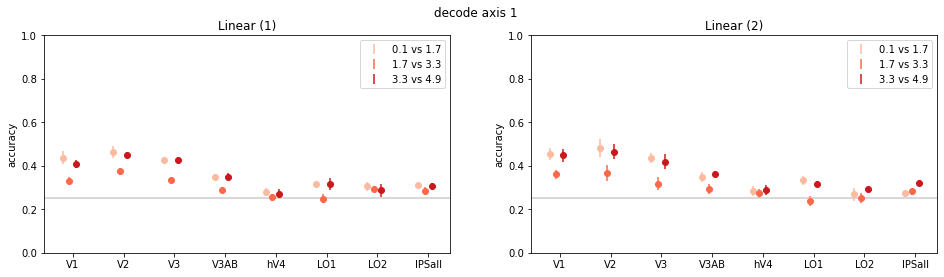

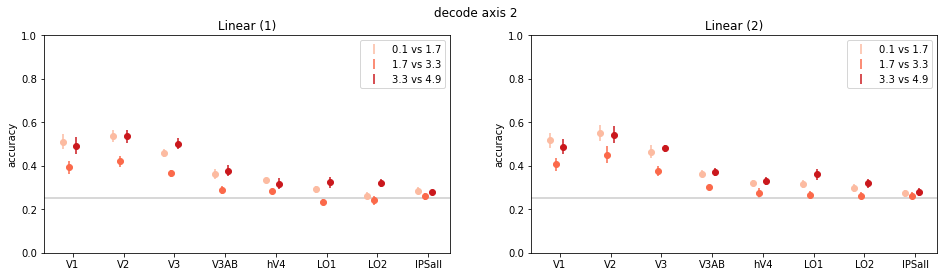

In [20]:
pair_colors = cm.Reds(np.linspace(0,1,5))[1:4,:]
pair_names = ['%s vs %s'%(p1,p2) for p1,p2 in pairs_do]

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

for ii, axis_name in enumerate(['axis 1','axis 2']):
    
    plt.figure(figsize=(16,4))

    for ti, task_name in enumerate(task_names[0:2]):

        plt.subplot(1,2,ti+1)

        plt.axhline(1/4, color=[0.8, 0.8, 0.8])

        lh = []

        for pi, pair_name in enumerate(pair_names):

            x_ticks = np.arange(n_rois) + x_jitter[pi]

            vals = acc_eachcoordpair[:,:,ti,ii,pi]
            
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=pair_colors[pi])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=pair_colors[pi], linestyle='none')
            lh.append(h)
          
        plt.ylim([0, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('accuracy')

        plt.legend(lh,pair_names)

        plt.title(task_names[ti])

    plt.suptitle('decode %s'%axis_name)


In [203]:
within_pairs = np.mean(acc_eachcoordpair[:,:,:,:,[0,2]], axis=4)
across_pairs = acc_eachcoordpair[:,:,:,:,1]

avals = np.concatenate([within_pairs[:,:,:,:,None], across_pairs[:,:,:,:,None]], axis=4)
avals.shape

(7, 8, 4, 2, 2)

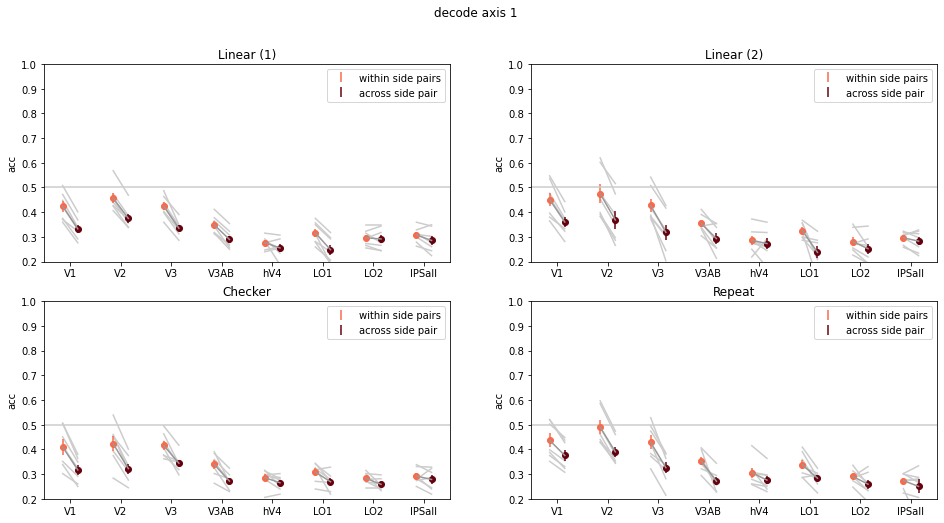

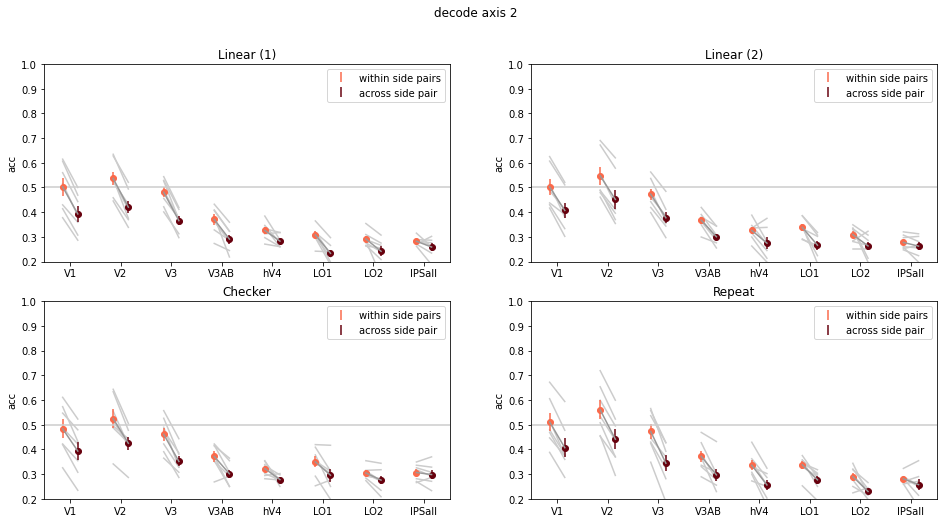

In [205]:
pair_colors = cm.Reds(np.linspace(0,1,5))[[2,4],:]
pair_names = ['within side pairs','across side pair']

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.15, 0.15, 2)

for ii, axis_name in enumerate(['axis 1','axis 2']):
    
    plt.figure(figsize=(16,8))

    for ti in ti_plot:

        plt.subplot(2,2,ti+1)

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        lh = []

        for pi, pair_name in enumerate(pair_names):

            x_ticks = np.arange(n_rois) + x_jitter[pi]

            vals = avals[:,:,ti,ii,pi]
            
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=pair_colors[pi])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=pair_colors[pi], linestyle='none')
            lh.append(h)
          
        for ri in range(n_rois):
            
            meanvals = np.mean(avals[:,ri,ti,ii,:], axis=0)
            plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, avals[:,ri,ti,ii,:].T,'-',color=[0.8, 0.8, 0.8], zorder=-10)

        plt.ylim([0.2, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('acc')

        plt.legend(lh,pair_names)

        plt.title(task_names[ti])

    plt.suptitle('decode %s'%axis_name)


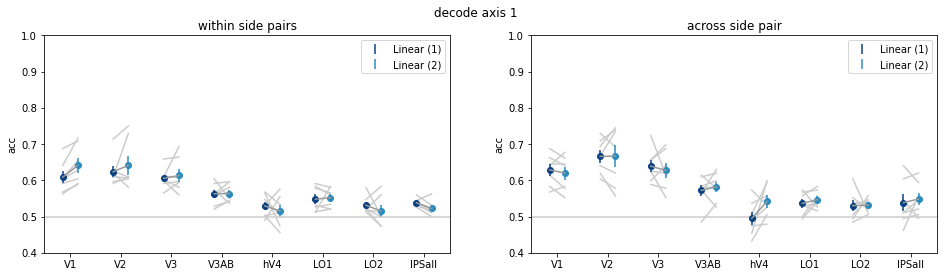

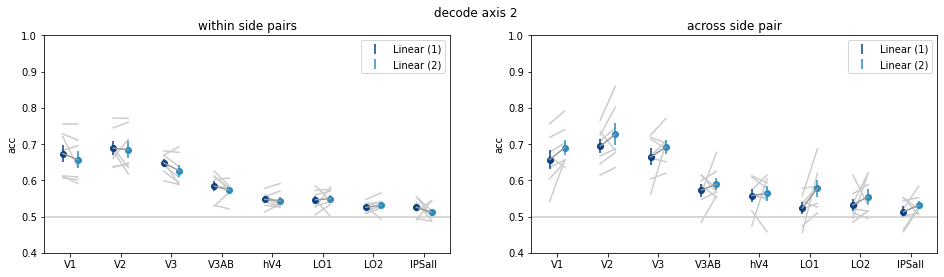

In [102]:
pair_names = ['within side pairs','across side pair']

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.15, 0.15, 2)

for ii, axis_name in enumerate(['axis 1','axis 2']):
    
    plt.figure(figsize=(16,4))

    for pi, pair_name in enumerate(pair_names):

        plt.subplot(1,2,pi+1)

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        lh = []

        for ti, task_name in enumerate(task_names[0:2]):

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = avals[:,:,ti,ii,pi]
            
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
          
        for ri in range(n_rois):
            
            meanvals = np.mean(avals[:,ri,[0,1],ii,pi], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, avals[:,ri,[0,1],ii,pi].T,'-',color=[0.8, 0.8, 0.8], zorder=-10)

        plt.ylim([0.4, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('acc')

        plt.legend(lh,task_names[0:2])

        plt.title(pair_name)

    plt.suptitle('decode %s'%axis_name)


In [22]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    for pi, [avals, pair_name] in enumerate(zip([within_pairs, across_pairs], \
                                                   pair_names)):

        vals = copy.deepcopy(avals[:,:,0:2,ii])

        class_df = pd.DataFrame(data={'subject': np.repeat(np.arange(n_subjects), n_rois*2), \
                                   'roi': np.tile(np.repeat(np.arange(n_rois), 2),[n_subjects,]), \
                                   'task': np.tile(np.arange(2), [n_subjects*n_rois,])})

        class_values = np.zeros((n_subjects*n_rois*2))
        for si in range(n_subjects):
            for ri in range(n_rois):
                inds = (class_df['subject']==si) & (class_df['roi']==ri)
                class_values[inds] = vals[si,ri,:]
        class_df['class_values'] = class_values

        model = AnovaRM(data=class_df, \
                        depvar='class_values', \
                        subject='subject', \
                        within = ['roi','task'],
                       )
        rm_result = model.fit()
        print('%s, %s'%(axis_name, pair_name))
        print(rm_result)

axis 1 (x), within side pairs
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
roi      18.1616 7.0000 42.0000 0.0000
task      0.0460 1.0000  6.0000 0.8373
roi:task  2.5425 7.0000 42.0000 0.0282

axis 1 (x), across side pair
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
roi      18.2411 7.0000 42.0000 0.0000
task      0.6713 1.0000  6.0000 0.4439
roi:task  1.1212 7.0000 42.0000 0.3682

axis 2 (y), within side pairs
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
roi      39.6879 7.0000 42.0000 0.0000
task      1.9257 1.0000  6.0000 0.2146
roi:task  0.7056 7.0000 42.0000 0.6672

axis 2 (y), across side pair
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
roi      37.5501 7.0000 42.0000 0.0000
task     10.4281 1.0000  6.0000 0.0179
roi:task  0.4573 7.0000 42.0000 0.8595



Text(0.5, 0.98, 'ratio of across-side accuracy to within-side accuracy')

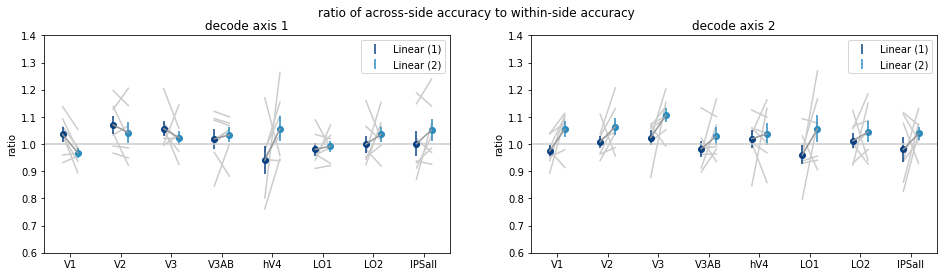

In [12]:
ratio = across_pairs/within_pairs

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.15, 0.15, 2)

    
plt.figure(figsize=(16,4))

for ii, axis_name in enumerate(['axis 1','axis 2']):

    plt.subplot(1,2,ii+1)

    plt.axhline(1, color=[0.8, 0.8, 0.8])

    lh = []

    avals = ratio

    for ti, task_name in enumerate(task_names[0:2]):

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti,ii]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(avals[:,ri,[0,1],ii], axis=0)
        plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.plot(ri+x_jitter, avals[:,ri,0:2,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
    plt.ylim([0.6, 1.4])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('ratio')

    plt.legend(lh,task_names[0:2])

    plt.title('decode %s'%axis_name)

plt.suptitle('ratio of across-side accuracy to within-side accuracy')

In [13]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    vals = copy.deepcopy(ratio[:,:,0:2,ii])

    class_df = pd.DataFrame(data={'subject': np.repeat(np.arange(n_subjects), n_rois*2), \
                               'roi': np.tile(np.repeat(np.arange(n_rois), 2),[n_subjects,]), \
                               'task': np.tile(np.arange(2), [n_subjects*n_rois,])})

    class_values = np.zeros((n_subjects*n_rois*2))
    for si in range(n_subjects):
        for ri in range(n_rois):
            inds = (class_df['subject']==si) & (class_df['roi']==ri)
            class_values[inds] = vals[si,ri,:]
    class_df['class_values'] = class_values

    model = AnovaRM(data=class_df, \
                    depvar='class_values', \
                    subject='subject', \
                    within = ['roi','task'],
                   )
    rm_result = model.fit()
    print('Classify %s'%axis_name)
    print(rm_result)

Classify axis 1 (x)
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
roi       0.7917 7.0000 42.0000 0.5983
task      1.4696 1.0000  6.0000 0.2710
roi:task  1.7625 7.0000 42.0000 0.1207

Classify axis 2 (y)
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
roi       0.8017 7.0000 42.0000 0.5905
task     10.7990 1.0000  6.0000 0.0167
roi:task  0.2924 7.0000 42.0000 0.9532



In [14]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    vals = copy.deepcopy(ratio[:,:,0:2,ii])

    tstats_task = np.zeros((n_rois,),dtype=float)
    pvals_task = np.zeros((n_rois,),dtype=float)
    pvals_nonpar_task = np.zeros((n_rois,),dtype=float)
    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 1223534
    for rr in range(n_rois):

        t1_values = vals[:,rr,0]
        t2_values = vals[:,rr,1]

        stats = scipy.stats.ttest_rel(t1_values, t2_values)

        tstats_task[rr] = stats.statistic
        pvals_task[rr] = stats.pvalue

        p, d = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                               n_iter=10000, rndseed=rndseed)    
        pvals_nonpar_task[rr] = p

        subj_diffs = t1_values - t2_values
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

    # p_values = pvals_task
    p_values = pvals_nonpar_task
    # orig_shape = p_values.shape
    # mask_fdr, pvals_fdr = statsmodels.stats.multitest.fdrcorrection(p_values.ravel(), 
    #                                                                 alpha=0.01)
    # mask_fdr = np.reshape(mask_fdr, orig_shape)
    # pvals_fdr = np.reshape(pvals_fdr, orig_shape)

    task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                            'pvalue': p_values, \
                               # 'pvalue_fdr': pvals_fdr, 'sig_fdr': mask_fdr, \
                               'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    # mask_fdr_vert = mask_fdr
    print('\n%s'%axis_name)
    print(task_df.round(3))


axis 1 (x)
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                           2.969   0.066             5
V2                           1.047   0.302             5
V3                           0.852   0.412             4
V3AB                        -0.500   0.680             4
hV4                         -1.495   0.212             5
LO1                         -0.402   0.669             4
LO2                         -0.776   0.470             4
IPSall                      -1.424   0.233             4

axis 2 (y)
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                          -2.362   0.062             6
V2                          -1.389   0.229             6
V3                          -1.887   0.108             6
V3AB                        -1.215   0.283             5
hV4                         -0.336   0.754             5
LO1                         -1.527   0.175             5
LO2                         -0.660   0.524             5
IPSall 

Text(0.5, 0.98, 'ratio of across-side accuracy to within-side accuracy')

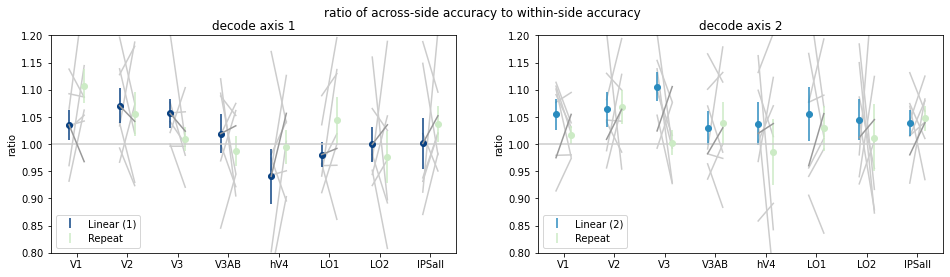

In [32]:
ratio = across_pairs/within_pairs

# ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.15, 0.15, 2)

    
plt.figure(figsize=(16,4))

for ii, axis_name in enumerate(['axis 1','axis 2']):

    plt.subplot(1,2,ii+1)

    plt.axhline(1, color=[0.8, 0.8, 0.8])

    lh = []

    avals = ratio
    
    if ii==0:
        ti_plot = [0,3]
    else:
        ti_plot = [1,3]

    for tii, ti in enumerate(ti_plot):

        task_name = task_names[ti]
        
        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = avals[:,:,ti,ii]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(avals[:,ri,[0,1],ii], axis=0)
        plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.plot(ri+x_jitter, avals[:,ri,ti_plot,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
    plt.ylim([0.8, 1.2])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('ratio')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('decode %s'%axis_name)

plt.suptitle('ratio of across-side accuracy to within-side accuracy')

In [11]:
ratio.shape

(7, 8, 4, 2)

In [21]:
ii = 1
vals = copy.deepcopy(ratio[:,:,0:2,ii])

tstats_task = np.zeros((n_rois,),dtype=float)
pvals_task = np.zeros((n_rois,),dtype=float)
pvals_nonpar_task = np.zeros((n_rois,),dtype=float)
n_subs_samedir = np.zeros((n_rois,),dtype=int)

rndseed = 1223534
for rr in range(n_rois):
    
    t1_values = vals[:,rr,0]
    t2_values = vals[:,rr,1]
    
    stats = scipy.stats.ttest_rel(t1_values, t2_values)
    
    tstats_task[rr] = stats.statistic
    pvals_task[rr] = stats.pvalue
    
    p, d = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                           n_iter=10000, rndseed=rndseed)    
    pvals_nonpar_task[rr] = p
    
    subj_diffs = t1_values - t2_values
    n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

# p_values = pvals_task
p_values = pvals_nonpar_task
# orig_shape = p_values.shape
# mask_fdr, pvals_fdr = statsmodels.stats.multitest.fdrcorrection(p_values.ravel(), 
#                                                                 alpha=0.01)
# mask_fdr = np.reshape(mask_fdr, orig_shape)
# pvals_fdr = np.reshape(pvals_fdr, orig_shape)
   
task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                        'pvalue': p_values, \
                           # 'pvalue_fdr': pvals_fdr, 'sig_fdr': mask_fdr, \
                           'n_subs_indiv': n_subs_samedir}, \
                          index=roi_names)
# mask_fdr_vert = mask_fdr
task_df.round(3)

,t-stat for task 1 > task 2,pvalue,n_subs_indiv
V1,-2.362,0.062,6
V2,-1.389,0.229,6
V3,-1.887,0.108,6
V3AB,-1.215,0.283,5
hV4,-0.336,0.754,5
LO1,-1.527,0.175,5
LO2,-0.660,0.524,5
IPSall,-1.008,0.338,4


Text(0.5, 0.98, 'ratio of across-side accuracy to within-side accuracy')

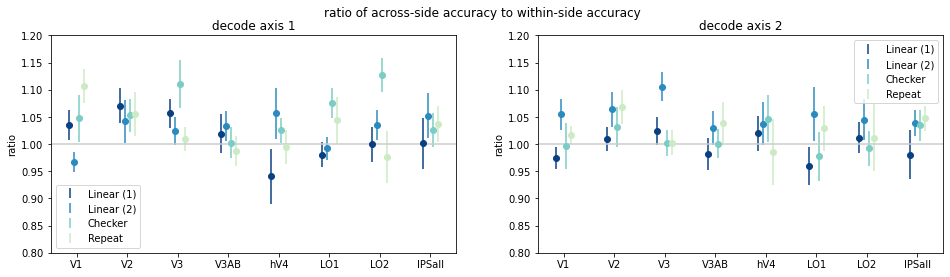

In [11]:
ratio = across_pairs/within_pairs

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.15, 0.15, 4)

    
plt.figure(figsize=(16,4))

for ii, axis_name in enumerate(['axis 1','axis 2']):

    plt.subplot(1,2,ii+1)

    plt.axhline(1, color=[0.8, 0.8, 0.8])

    lh = []

    avals = ratio

    for ti, task_name in enumerate(np.array(task_names)[ti_plot]):

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti,ii]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

   
    plt.ylim([0.8, 1.2])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('ratio')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('decode %s'%axis_name)

plt.suptitle('ratio of across-side accuracy to within-side accuracy')

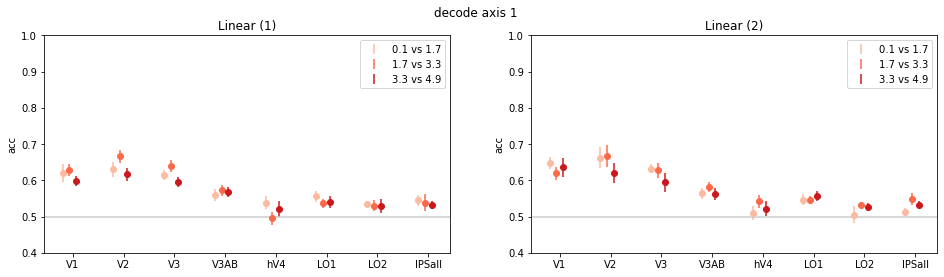

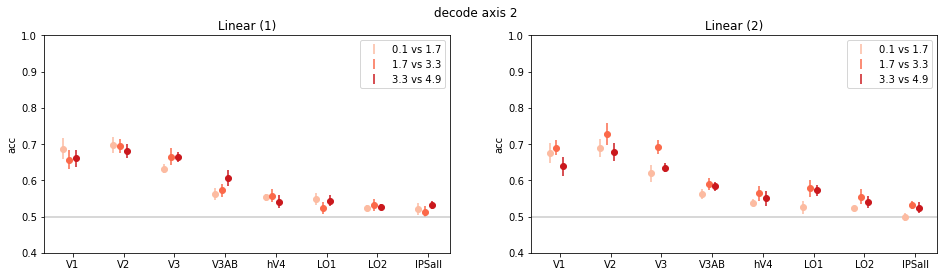

In [15]:
pair_colors = cm.Reds(np.linspace(0,1,5))[1:4,:]
pair_names = ['%s vs %s'%(p1,p2) for p1,p2 in pairs_do]

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

for ii, axis_name in enumerate(['axis 1','axis 2']):
    
    plt.figure(figsize=(16,4))

    for ti, task_name in enumerate(task_names[0:2]):

        plt.subplot(1,2,ti+1)

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        lh = []

        for pi, pair_name in enumerate(pair_names):

            x_ticks = np.arange(n_rois) + x_jitter[pi]

            vals = acc_eachcoordpair[:,:,ti,ii,pi]
            
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=pair_colors[pi])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=pair_colors[pi], linestyle='none')
            lh.append(h)
          
        plt.ylim([0.4, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('acc')

        plt.legend(lh,pair_names)

        plt.title(task_names[ti])

    plt.suptitle('decode %s'%axis_name)


#### load gist features

In [25]:
import h5py
f = []
feat_dir = os.path.join(root, 'Analysis', 'image_similarity', 'features')

fn = os.path.join(feat_dir, 'gist', 'Images_grid3_gistdescriptors_4ori_4blocks.h5py')
print(fn)
with h5py.File(fn, 'r') as file:
    
    f = np.array(file['/features'])
    file.close()
    
labs = pd.read_csv(os.path.join(feat_dir, 'Image_labels_grid3.csv'))

pts = np.array([labs['coord_axis1'], labs['coord_axis2']]).T

gi = [np.argmin(np.sum((pts-g)**2, axis=1)) for g in grid_pts]

f_main = f[gi,:]

# compute all pairwise euclidean distances

gist_distances = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(f_main, 'euclidean'))


/usr/local/serenceslab/maggie/shapeDim/Analysis/image_similarity/features/gist/Images_grid3_gistdescriptors_4ori_4blocks.h5py


In [29]:
f_main.shape

un_coord = np.unique(grid_pts[:,0])

pairs_do = [un_coord[[0,1]], un_coord[[1,2]], un_coord[[2,3]]]

pair_names = ['%s vs %s'%(p1,p2) for p1,p2 in pairs_do]
pair_names

['0.1 vs 1.7', '1.7 vs 3.3', '3.3 vs 4.9']

In [27]:
grid_pts

array([[0.1, 0.1],
       [0.1, 1.7],
       [0.1, 3.3],
       [0.1, 4.9],
       [1.7, 0.1],
       [1.7, 1.7],
       [1.7, 3.3],
       [1.7, 4.9],
       [3.3, 0.1],
       [3.3, 1.7],
       [3.3, 3.3],
       [3.3, 4.9],
       [4.9, 0.1],
       [4.9, 1.7],
       [4.9, 3.3],
       [4.9, 4.9]])

In [50]:
mean_dist_grouped = np.zeros((2, 3))
std_dist_grouped = np.zeros((2, 3))

In [81]:
for ii in [0,1]:

    coord_actual = grid_pts[:,ii].round(2)
    coord_other = grid_pts[:,1-ii].round(2)

    for pi in [0,1,2]:
        
        d = []
        for pi2 in un_coord:

            pair = pairs_do[pi]

            ind1 = np.where((coord_actual==pair[0]) & (coord_other==pi2))[0][0]
            ind2 = np.where((coord_actual==pair[1]) & (coord_other==pi2))[0][0]

            d.append(gist_distances[ind1, ind2])

        mean_dist_grouped[ii,pi] = np.mean(d)
        std_dist_grouped[ii,pi] = np.std(d)


In [62]:
(coord_actual==pair[0]), (coord_other==pi2)

(array([False, False,  True, False, False, False,  True, False, False,
        False,  True, False, False, False,  True, False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]))

In [66]:
inds2

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True])

In [56]:
mean_dist_grouped[ii,pi]

0.2321104907258385

In [55]:
std_dist_grouped[ii,pi]

0.09859051269736449

Text(0.5, 0.98, 'average GIST distances between pairs of shapes')

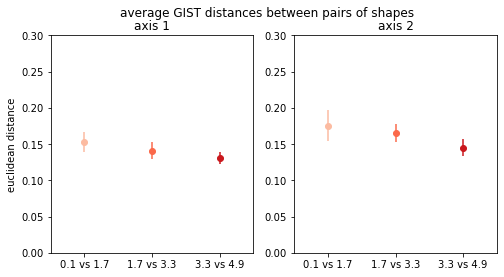

In [84]:
pair_colors = cm.Reds(np.linspace(0,1,5))[1:4,:]
pair_names = ['%s vs %s'%(p1,p2) for p1,p2 in pairs_do]

plt.figure(figsize=(8,4))

for ii in [0,1]:
    plt.subplot(1,2,ii+1)
    
    for pi in [0,1,2]:
        plt.plot(pi, mean_dist_grouped[ii,pi], 'o', color=pair_colors[pi,:])
        plt.errorbar(pi, mean_dist_grouped[ii,pi], std_dist_grouped[ii,pi], \
                     linestyle='none', color=pair_colors[pi,:])
    
    plt.xticks([0,1,2], pair_names)
    
    plt.ylim([0, 0.3])
    plt.xlim([-0.5, 2.5])
    
    if ii==0:
        plt.ylabel('euclidean distance')
    plt.title('axis %d'%(ii+1))
    
plt.suptitle('average GIST distances between pairs of shapes')


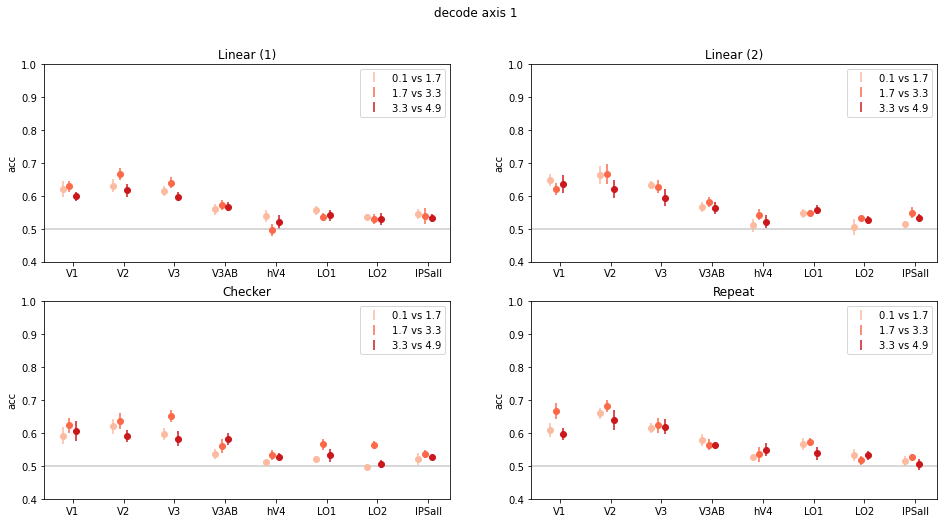

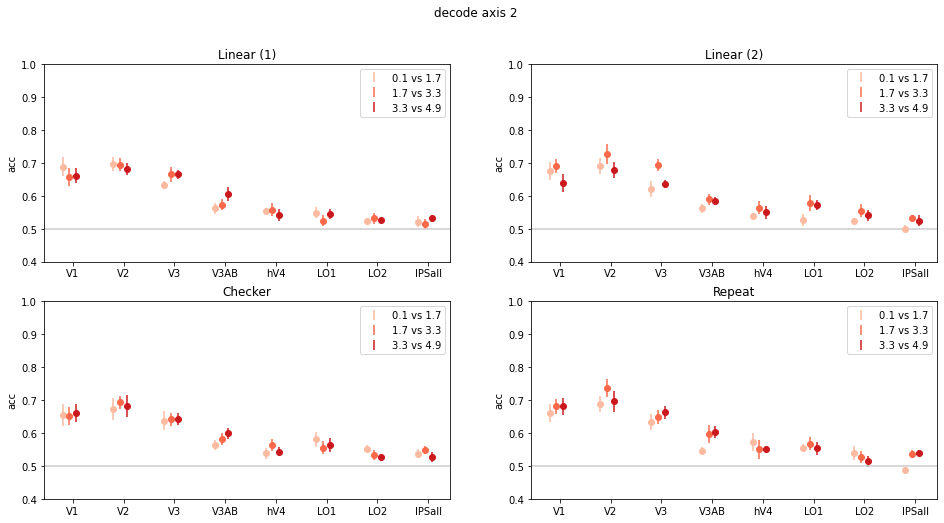

In [89]:
pair_colors = cm.Reds(np.linspace(0,1,5))[1:4,:]
pair_names = ['%s vs %s'%(p1,p2) for p1,p2 in pairs_do]

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

for ii, axis_name in enumerate(['axis 1','axis 2']):
    
    plt.figure(figsize=(16,8))

    for tii, ti in enumerate(ti_plot):

        plt.subplot(2,2,tii+1)

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        lh = []

        for pi, pair_name in enumerate(pair_names):

            x_ticks = np.arange(n_rois) + x_jitter[pi]

            vals = acc_eachcoordpair[:,:,ti,ii,pi]
            
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=pair_colors[pi])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=pair_colors[pi], linestyle='none')
            lh.append(h)
          
        plt.ylim([0.4, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('acc')

        plt.legend(lh,pair_names)

        plt.title(task_names[ti])

    plt.suptitle('decode %s'%axis_name)


Text(0.5, 0.98, 'average all tasks')

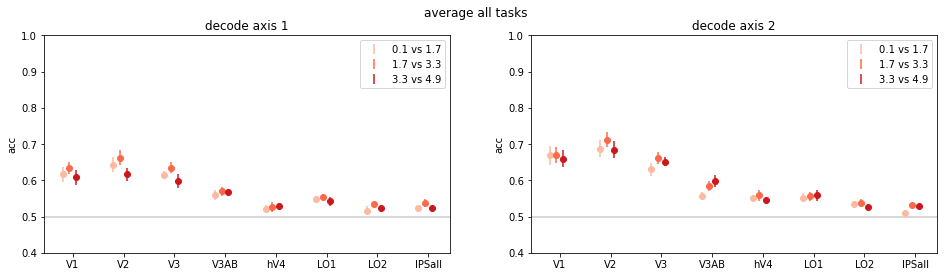

In [92]:
pair_colors = cm.Reds(np.linspace(0,1,5))[1:4,:]
pair_names = ['%s vs %s'%(p1,p2) for p1,p2 in pairs_do]

avals = np.mean(acc_eachcoordpair, axis=2)

x_jitter = np.linspace(-0.2, 0.2, 4)

plt.figure(figsize=(16,4))

for ii, axis_name in enumerate(['axis 1','axis 2']):

    plt.subplot(1,2,ii+1)

    plt.axhline(0.5, color=[0.8, 0.8, 0.8])

    lh = []

    for pi, pair_name in enumerate(pair_names):

        x_ticks = np.arange(n_rois) + x_jitter[pi]

        vals = avals[:,:,ii,pi]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=pair_colors[pi])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=pair_colors[pi], linestyle='none')
        lh.append(h)

    plt.ylim([0.4, 1])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('acc')

    plt.legend(lh,pair_names)

    
    plt.title('decode %s'%axis_name)

plt.suptitle('average all tasks')
